# <span style='color:SteelBlue'>P6 - Segmentez des clients d'un site e-commerce</span>

**1- Missions**

Réaliser une première **étude de faisabilité** d'un moteur de **classification d'articles** basé sur une **image et une description** pour l'**automatisation** de l'attribution de la **catégorie de l'article**.

**2- Notre Objectifs**

- analyser le jeu de données,
- réaliser :
    - un prétraitement des images,
    - un prétraitement des descriptions des produits
    - une réduction de dimension, 
    - Réaliser de clustering. 

La représentation graphique aidera à convaincre que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.




###  I- Import de bibliothéques:

In [74]:
import datetime
import time
import os
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import KMeans
import keras
from keras.preprocessing import image
import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import adjusted_rand_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical



##### Les fonctions:

In [75]:
def image_prep_fct(x) :

    " préparation des images avant de les entrainer avec les réseau de neuronne convulotifs "
    "pour les image de RGB la résolution est à 224*224"
    
    prepared_images = []
    for image_num in range(len(x)) :
        img = (load_img(
            x[image_num],target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        # img_array = tf.expand_dims(img_array, axis=0)
        img = preprocess_input(img)
        prepared_images.append(img)
    prepared_images_np = np.array(prepared_images)
    return prepared_images_np


In [76]:
def model() :

    " - Modél de reseau de neurone convulotif pour la classification d'image"
    "* include_top=False pour remplacer la derniere couche"
    " de classification par notre tache spécifique à nos besoin"
    " Parcouri toute les couches de vgg16 et les définir comme non entrainable"
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [77]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

##### Data exploratory:

In [78]:
data = pd.read_csv('data_clean.csv')
data = data.drop(columns = ['Unnamed: 0'])
data.shape

(1050, 23)

In [79]:
path = 'Images/'
data['image_path'] = [path + image for image in data['image']]


### Classification supervisée

* Encodage de catégories:

In [80]:
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(data["sub_cat 0"])
print(len(set(y)))


7


In [81]:
seed = 42
test_size = 0.2
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(data['image_path'], y, 
                                                    test_size=test_size, random_state=seed, shuffle=True, stratify=y)


In [82]:
train_x = np.asarray(X_train.tolist())
test_x = np.asarray(X_test.tolist())

In [83]:
image_train = image_prep_fct(train_x)
image_test = image_prep_fct(test_x)

c:\Python38\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [84]:
print(f'{image_train.shape},{image_test.shape}')

(840, 224, 224, 3),(210, 224, 224, 3)


In [85]:
x = image_train

* Encodage one-hot : conversion de l'output to_categorical crossentropy

In [86]:
nbr_classes = len(set(y))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

* Split: train/validation:

In [87]:
x_train, x_validate, y_train, y_validate = train_test_split(x, y_train, test_size = 0.25, random_state = 42, stratify = y_train)

In [88]:
x_train.shape

(630, 224, 224, 3)

* Modèle simple:
* J teste le modèl séquentiel de Keras , 
* Les résultats ne sont pas trés satisfaisante.

In [16]:
model_sequen = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        keras.layers.AveragePooling2D(pool_size=(4, 4)),
        keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
        keras.layers.AveragePooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        #keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(7, activation="softmax"),
    ]
)

model_sequen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (Average  (None, 56, 56, 3)         0         
 Pooling2D)                                                      
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 8)         224       
                                                                 
 average_pooling2d_1 (Avera  (None, 27, 27, 8)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        4672      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dropout (Dropout)           (None, 40000)             0

In [17]:
batch_size = 80
epochs = 50
model_sequen.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
histroy_model = model_sequen.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_validate, y_validate))

Epoch 1/50
8/8 [==============================] - 4s 328ms/step - loss: 157.6807 - accuracy: 0.2016 - val_loss: 82.8953 - val_accuracy: 0.1952
Epoch 2/50
8/8 [==============================] - 1s 176ms/step - loss: 33.0682 - accuracy: 0.2889 - val_loss: 6.5257 - val_accuracy: 0.2857
Epoch 3/50
8/8 [==============================] - 1s 169ms/step - loss: 3.8060 - accuracy: 0.4000 - val_loss: 4.4263 - val_accuracy: 0.3143
Epoch 4/50
8/8 [==============================] - 1s 174ms/step - loss: 1.8488 - accuracy: 0.5143 - val_loss: 2.6695 - val_accuracy: 0.3714
Epoch 5/50
8/8 [==============================] - 1s 170ms/step - loss: 1.0944 - accuracy: 0.6429 - val_loss: 2.1110 - val_accuracy: 0.3714
Epoch 6/50
8/8 [==============================] - 1s 173ms/step - loss: 0.9170 - accuracy: 0.7190 - val_loss: 2.0354 - val_accuracy: 0.3810
Epoch 7/50
8/8 [==============================] - 1s 168ms/step - loss: 0.7920 - accuracy: 0.7587 - val_loss: 1.9965 - val_accuracy: 0.3571
Epoch 8/50
8/8 [

In [18]:
# Score du dernier epoch
loss, accuracy = model_sequen.evaluate(x_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model_sequen.evaluate(x_validate, y_validate, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 1s 27ms/step - loss: 0.0031 - accuracy: 1.0000
Training Accuracy: 1.0000

7/7 [==============================] - 0s 33ms/step - loss: 3.8358 - accuracy: 0.4524
Validation Accuracy:  0.4524


In [19]:
# Score de l'epoch optimal
loss, accuracy = model_sequen.evaluate(x_validate, y_validate, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model_sequen.evaluate(image_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.4524
Test Accuracy       :  0.4667


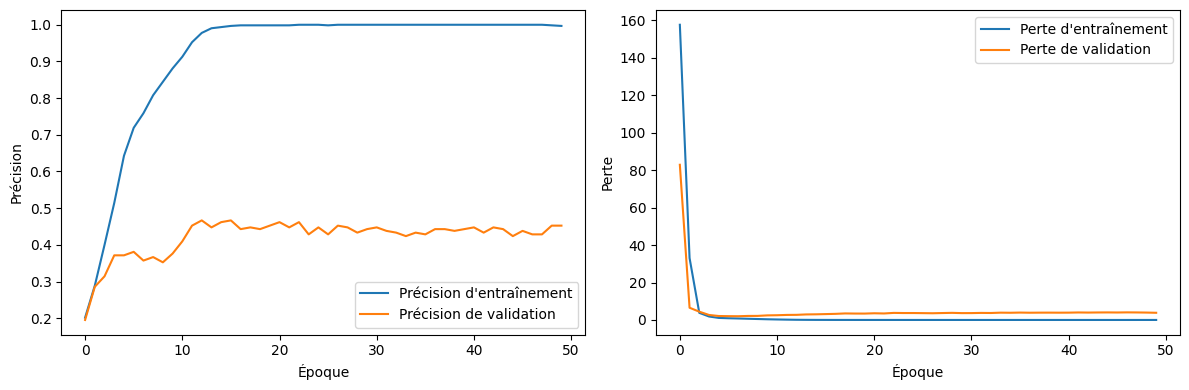

In [20]:
plt.figure(figsize=(12, 4))
# Premier sous-graphique : Précision d'entraînement et de validation
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, sous-graphique 1
plt.plot(histroy_model.history['accuracy'], label='Précision d\'entraînement')
plt.plot(histroy_model.history['val_accuracy'], label='Précision de validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
# Deuxième sous-graphique : Perte d'entraînement et de validation
plt.subplot(1, 2, 2)  
plt.plot(histroy_model.history['loss'], label='Perte d\'entraînement')
plt.plot(histroy_model.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.tight_layout()  
plt.show()


In [21]:
y_val_num = np.argmax(y_validate, axis=1)
y_val_pred = np.argmax(model_sequen.predict(x_validate), axis=1)
y_val_num = np.argmax(y_validate, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 0s 28ms/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[3 2 6 2 3 2 4 0 2 5 2 6 1 5 1 1 0 1 1 5 0 2 2 6 3 6 1 1 2 2 6 3 4 0 5 5 3
 5 6 6 4 3 5 5 5 5 1 6 0 6 3 0 4 0 6 6 3 4 4 0 2 0 6 3 0 2 2 3 1 5 1 3 5 2
 4 6 4 6 5 1 3 4 5 4 2 4 4 2 3 0 0 5 1 3 5 4 3 0 2 0 5 0 5 1 4 3 1 4 1 3 3
 0 5 4 5 2 0 6 4 0 5 5 5 3 0 5 2 6 3 4 3 5 3 6 6 4 3 5 1 6 2 3 5 3 3 1 3 0
 5 4 0 3 1 5 1 1 1 3 1 6 1 3 5 4 0 1 5 0 0 1 0 5 1 6 3 2 3 0 3 0 6 3 3 1 6
 5 0 4 3 1 6 0 6 4 6 4 5 2 5 3 3 6 4 3 3 1 6 4 2 5]


In [22]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]


[[13  3  2  7  3  2  0]
 [ 3 13  3  4  6  1  0]
 [ 3  2 11  5  5  3  1]
 [ 4  2  1 11  3  6  3]
 [ 6  6  2  6  7  1  2]
 [ 0  2  1  4  1 20  2]
 [ 0  1  2  3  1  3 20]]

              precision    recall  f1-score   support

           0       0.45      0.43      0.44        30
           1       0.45      0.43      0.44        30
           2       0.50      0.37      0.42        30
           3       0.28      0.37      0.31        30
           4       0.27      0.23      0.25        30
           5       0.56      0.67      0.61        30
           6       0.71      0.67      0.69        30

    accuracy                           0.45       210
   macro avg       0.46      0.45      0.45       210
weighted avg       0.46      0.45      0.45       210



<Axes: >

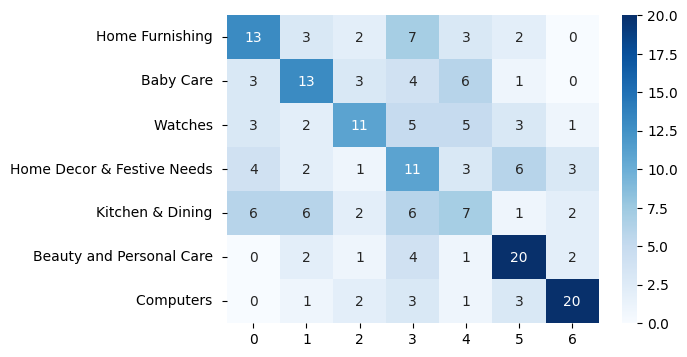

In [23]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["sub_cat 0"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

#### Analyse des résultats:
*****************************
* Avec le modél de neurones simple , modèle de sequential(), on arrive a predire toute les classe , la classe la moins predict est home Furnishing, mais ce modèle presente un overfithing et surtout beaucoup de erreurs entres les classes.
***********************
******
*****


### Modèle VGG16

* Test Model:

* "tf.device('/gpu:0'):Pour tache d'acceleration des calculs"
* "Création des collable"
* "ModelCheckpoint: permet d'enregistrer les metrique si y'on a une evaluation sur la fct loss"
* "seuls les poids du modèle ayant la meilleure performance sur la métrique "
"de validation seront enregistrés,"
* [checkpoint, es]:Regrouper les callable crée dans une liste et puis

In [89]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = model()
# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

* Entraîner le modèle de réseau de neurones model1 sur un jeu de données d'entraînement (X_train et y_train) avec l'algorithme d'optimisation Adam.

* d'optimisation Adam sera utilisé pour ajuster les poids du modèle pendant l'entraînement. 
* L'argument loss='categorical_crossentropy' c une loss function,"categorical cross-entropy", fonction de perte couramment utilisée pour les problèmes de classification multiclasse.
* verbose=1:afficher les détails de l'entraînement ( la perte et la précision à chaque époque) pendant l'entraînement.

In [90]:
# Compiler le modèle avec un optimiseur et une fonction de perte
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(x_train, y_train, epochs=50, batch_size=80, 
                       callbacks=callbacks_list, validation_data=(x_validate, y_validate), verbose=1)


Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 8.3961 - accuracy: 0.2810 
Epoch 1: val_loss improved from inf to 1.74766, saving model to .\model1_best_weights.h5


c:\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 130s 17s/step - loss: 8.3961 - accuracy: 0.2810 - val_loss: 1.7477 - val_accuracy: 0.6667
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.9243 - accuracy: 0.6206 
Epoch 2: val_loss improved from 1.74766 to 1.24301, saving model to .\model1_best_weights.h5
8/8 [==============================] - 117s 15s/step - loss: 2.9243 - accuracy: 0.6206 - val_loss: 1.2430 - val_accuracy: 0.8048
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 1.6010 - accuracy: 0.7397 
Epoch 3: val_loss improved from 1.24301 to 1.15103, saving model to .\model1_best_weights.h5
8/8 [==============================] - 117s 15s/step - loss: 1.6010 - accuracy: 0.7397 - val_loss: 1.1510 - val_accuracy: 0.8143
Epoch 4/50
8/8 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.7921 
Epoch 4: val_loss improved from 1.15103 to 1.00526, saving model to .\model1_best_weights.h5
8/8 [==============================] - 117s 15s/step - 

In [91]:
# Score du dernier epoch
loss, accuracy = model1.evaluate(x_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(x_validate, y_validate, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 87s 4s/step - loss: 0.0167 - accuracy: 0.9984
Training Accuracy: 0.9984

7/7 [==============================] - 29s 4s/step - loss: 0.7879 - accuracy: 0.8619
Validation Accuracy:  0.8619


In [92]:
# Score de l'epoch optimal
model1.load_weights(model1_save_path1)
loss, accuracy = model1.evaluate(x_validate, y_validate, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(image_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8619
Test Accuracy       :  0.7810


* Visualisation 

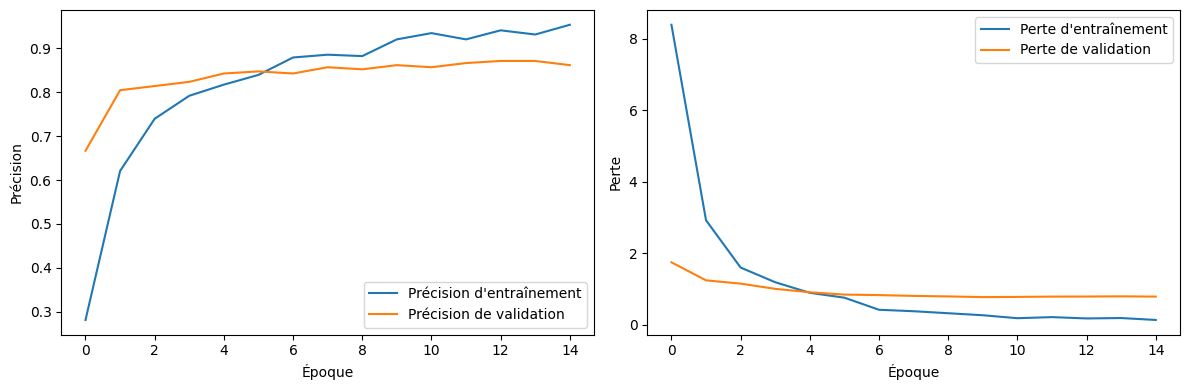

In [93]:
plt.figure(figsize=(12, 4))
# Précision d'entraînement et de validation
plt.subplot(1, 2, 1) 
plt.plot(history1.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history1.history['val_accuracy'], label='Précision de validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
#  Perte d'entraînement et de validation
plt.subplot(1, 2, 2)  
plt.plot(history1.history['loss'], label='Perte d\'entraînement')
plt.plot(history1.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.tight_layout()  
plt.show()


In [94]:
y_val_num = np.argmax(y_validate, axis=1)
y_val_pred = np.argmax(model1.predict(x_validate), axis=1)
y_val_num = np.argmax(y_validate, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 29s 4s/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[0 2 6 2 4 1 3 0 2 4 2 6 1 6 2 2 1 1 4 2 4 2 6 6 3 3 4 1 2 4 6 3 4 2 6 5 2
 5 6 6 0 2 1 5 2 0 1 6 0 6 5 3 3 1 5 3 5 4 3 0 4 0 6 6 4 5 0 3 1 2 5 6 5 2
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 3 3 5 4 3 5 0 6 0 2 0 3 0 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 5 0 5 5 3 0 0 3 2 6 3 6 5 1 2 3 6 1 2 5 2 4 3 3 6 3 0 4 5 0
 5 4 0 6 0 0 4 0 2 3 1 2 4 0 5 2 4 1 5 6 4 1 0 2 1 6 4 2 4 3 4 0 6 2 3 4 6
 5 0 2 3 1 6 0 6 1 5 0 0 0 2 3 1 6 1 2 1 3 6 3 6 5]


In [95]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)


[[26  0  0  2  2  0  0]
 [ 0 24  2  3  0  1  0]
 [ 0  0 28  0  1  0  1]
 [ 0  1  3 24  0  0  2]
 [ 4  0  0  2 24  0  0]
 [ 1  0  1  0  0 27  1]
 [ 0  1  0  1  0  0 28]]


In [96]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[26  0  0  2  2  0  0]
 [ 0 24  2  3  0  1  0]
 [ 0  0 28  0  1  0  1]
 [ 0  1  3 24  0  0  2]
 [ 4  0  0  2 24  0  0]
 [ 1  0  1  0  0 27  1]
 [ 0  1  0  1  0  0 28]]

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.92      0.80      0.86        30
           2       0.82      0.93      0.87        30
           3       0.75      0.80      0.77        30
           4       0.89      0.80      0.84        30
           5       0.96      0.90      0.93        30
           6       0.88      0.93      0.90        30

    accuracy                           0.86       210
   macro avg       0.87      0.86      0.86       210
weighted avg       0.87      0.86      0.86       210



<Axes: >

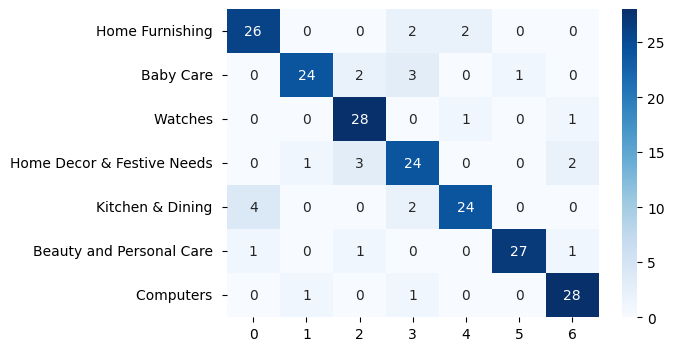

In [97]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["sub_cat 0"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

##### Analyse des résultats:

- On arrive à trouver toute les catégories , la classe moins predict est la classe Kichen et Dining, 
* Le modele vgg16 arrive à predire toute les category avec un accuracy de :0.83
********
******
********


#### 2- Approche imageDatagenerator avec data augmentation:

* ImageDataGenerator:une classe fournie par keras/Tensorflow, qui pemet de générer les lots(batches) avec des transformation.

* Data augmentation : Consiste a appliquer le stransformations aléatoires aux images existantes pour créer de nouvelles images synthétiques, Ces transformations peuvent inclure des rotations, des retournements, des zooms, des translations, des changements d'echelles, des changements de luminosité,ect.

* Génération de nouvelles images: Lorsque vous utilisez l'imageDataGenerator, il génère de nouvelles images à volée pendant l'entrainement, cela signifie qua chaque époque(iteration sur l'ensemble de données) le modele voit des images différents en raison des transformations aléatoires appliquées par le générateur

In [33]:
X_Train, X_Test, y_Train, y_Test = train_test_split(data['image_path'], data['sub_cat 0'], 
                                                    test_size=test_size, random_state=seed, shuffle=True, stratify=data['sub_cat 0'])


In [34]:
df_train = pd.DataFrame(columns = ['image_path','category'])
df_train['image_path'] = X_Train
df_train['category'] = y_Train
df_test = pd.DataFrame(columns = ['image_path','category'])
df_test['image_path'] = X_Test
df_test['category'] = y_Test

In [35]:
# Pour mélanger les images, classées initalement par classe
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)


In [36]:
batch_size = 36

def data_flow_fct(data, generator, data_type=None) :
    "Cette fonction génère un flux de données avec generateur qui est utilisé pour prétraiter les images"
    "avant leur utilisation dans AP"
    "generateur: effectuer la transformation et le prétraitement des images"

    data_flow = generator.flow_from_dataframe(data, directory = '',
                                x_col='image_path', y_col='category',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [37]:
# Créer un générateur de flux de données pour l'entraînement avec data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(df_train,train_datagen, data_type='training')
val_flow = data_flow_fct(df_train, train_datagen, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [38]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = model()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
 2/18 [==>...........................] - ETA: 2:04 - loss: 8.8023 - accuracy: 0.1944

c:\Python38\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


18/18 [==============================] - ETA: 0s - loss: 4.1445 - accuracy: 0.4286
Epoch 1: val_loss improved from inf to 1.05060, saving model to .\model2_best_weights.h5
18/18 [==============================] - 190s 11s/step - loss: 4.1445 - accuracy: 0.4286 - val_loss: 1.0506 - val_accuracy: 0.7143
Epoch 2/50


c:\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - ETA: 0s - loss: 1.6936 - accuracy: 0.6651
Epoch 2: val_loss did not improve from 1.05060
18/18 [==============================] - 190s 11s/step - loss: 1.6936 - accuracy: 0.6651 - val_loss: 1.1202 - val_accuracy: 0.7381
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.1808 - accuracy: 0.7127
Epoch 3: val_loss improved from 1.05060 to 0.88443, saving model to .\model2_best_weights.h5
18/18 [==============================] - 192s 11s/step - loss: 1.1808 - accuracy: 0.7127 - val_loss: 0.8844 - val_accuracy: 0.7762
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.7810
Epoch 4: val_loss did not improve from 0.88443
18/18 [==============================] - 183s 10s/step - loss: 0.7398 - accuracy: 0.7810 - val_loss: 0.8956 - val_accuracy: 0.8000
Epoch 5/50
18/18 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.7873
Epoch 5: val_loss improved from 0.88443 to 0.78822, sav

In [40]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8048
Test Accuracy       :  0.7810


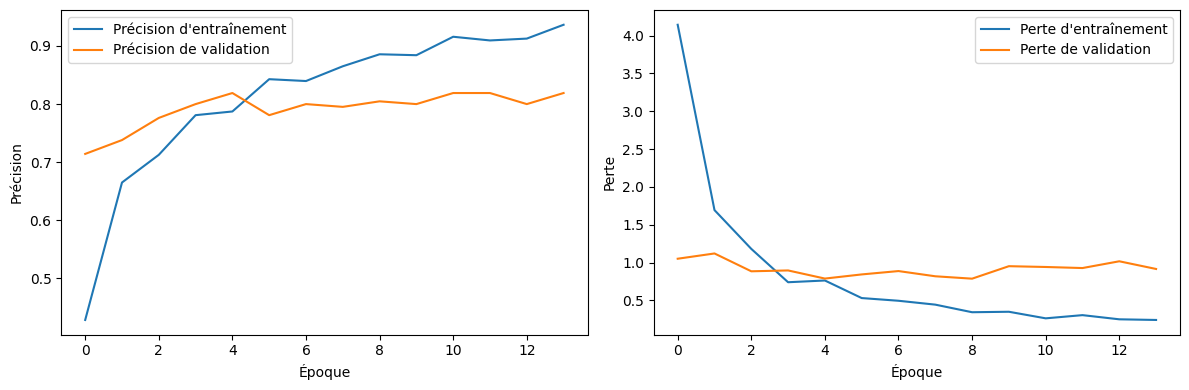

In [41]:
plt.figure(figsize=(12, 4))
#  Précision d'entraînement et de validation
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, sous-graphique 1
plt.plot(history2.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history2.history['val_accuracy'], label='Précision de validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
#  Perte d'entraînement et de validation
plt.subplot(1, 2, 2)  
plt.plot(history2.history['loss'], label='Perte d\'entraînement')
plt.plot(history2.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.tight_layout()  
plt.show()


##### Matrice de confusion:

In [43]:
y_val_num = np.argmax(y_validate, axis=1)
y_val_pred = np.argmax(model2.predict(x_validate), axis=1)
y_val_num = np.argmax(y_validate, axis=1)
print(y_val_num)
print()
print(y_val_pred)

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))


7/7 [==============================] - 27s 4s/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[0 2 6 2 4 1 3 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 1 1 2 4 6 3 4 2 6 5 2
 5 6 6 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 3 1 2 5 3 5 2
 4 6 2 4 5 1 4 0 5 4 1 3 2 2 3 1 3 5 4 3 5 0 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 3 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 4 0 6 2 1 4 6
 5 0 2 3 1 6 0 6 1 5 4 5 0 3 3 1 6 1 2 1 3 6 3 6 5]
[[25  2  0  1  2  0  0]
 [ 0 27  1  2  0  0  0]
 [ 0  0 29  1  0  0  0]
 [ 0  0  1 28  0  0  1

<Axes: >

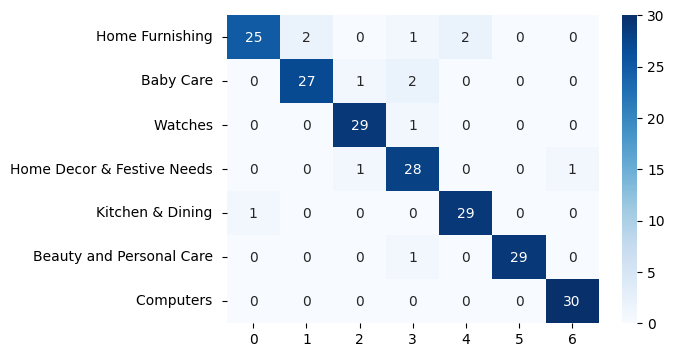

In [44]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["sub_cat 0"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")